Binance 客戶端初始化成功。
正在獲取 BTCUSDT 從 1 Jan, 2023 到 現在 的 1d K 線數據...

成功獲取 934 條 BTCUSDT K 線數據。
數據預覽：
                             Open      High       Low     Close        Volume
timestamp                                                                    
2023-01-01 23:59:59.999  16541.77  16628.00  16499.01  16616.75   96925.41374
2023-01-02 23:59:59.999  16617.17  16799.23  16548.70  16672.87  121888.57191
2023-01-03 23:59:59.999  16672.78  16778.40  16605.28  16675.18  159541.53733
2023-01-04 23:59:59.999  16675.65  16991.87  16652.66  16850.36  220362.18862
2023-01-05 23:59:59.999  16850.36  16879.82  16753.00  16831.85  163473.56641
                              Open       High        Low      Close  \
timestamp                                                             
2025-07-18 23:59:59.999  119177.56  120820.71  116812.76  117924.84   
2025-07-19 23:59:59.999  117924.84  118499.90  117277.34  117840.00   
2025-07-20 23:59:59.999  117840.01  118856.80  116467.02  117265.12   
20

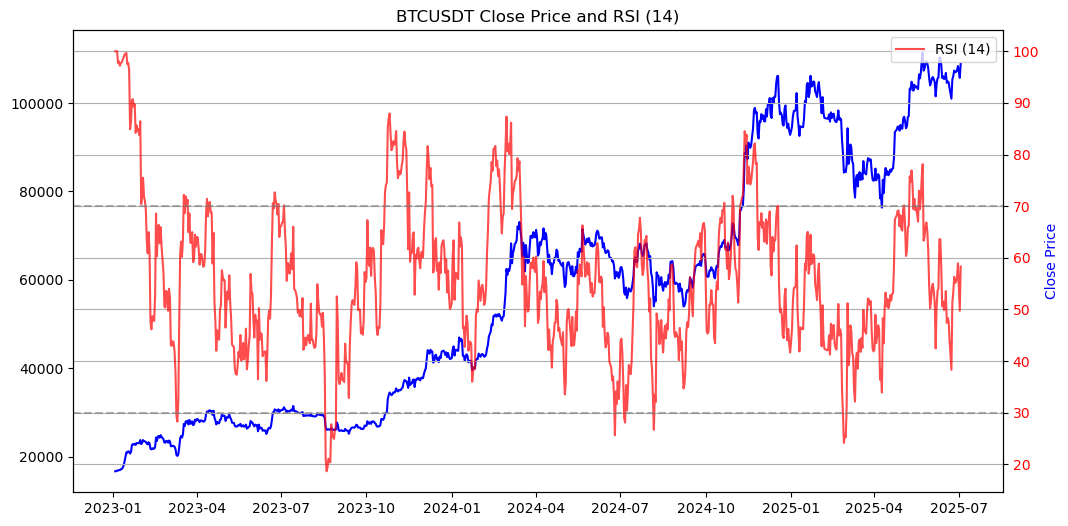

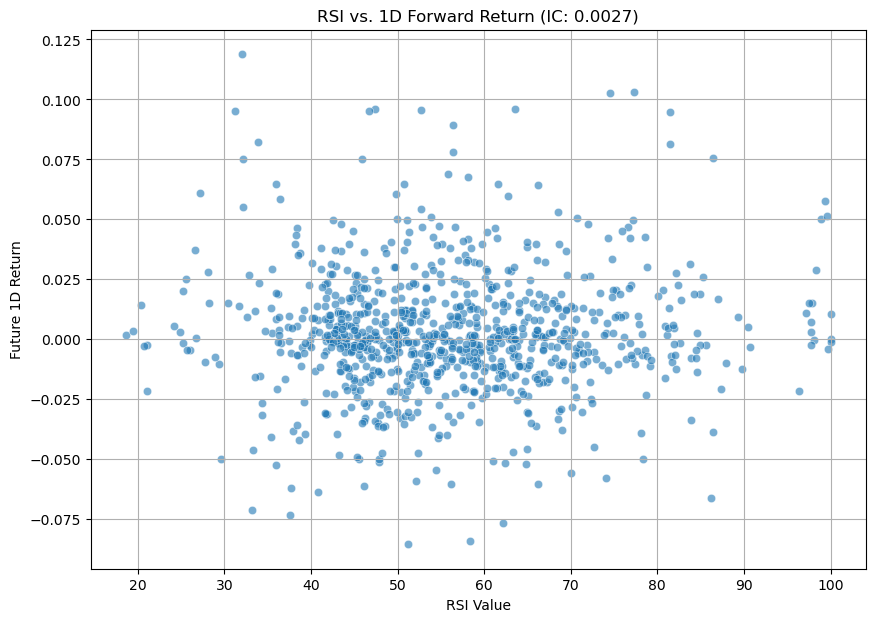


分析完成。


In [1]:
import pandas as pd
from binance.client import Client
from datetime import datetime
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 配置與數據獲取 ---
# 替換成你自己的 Binance API Key 和 Secret Key
# 注意：請確保這些金鑰是安全的，不要直接提交到公共倉庫！
# 建議使用環境變數或專門的配置檔案來管理。
API_KEY = 'iH6yaxbSK4h8tIkQvc6jnJFcpuUIOlqDP3tn4ZPPdH9J9M3ARko4Co20Iy3k84Y0' # 例如: os.environ.get('BINANCE_API_KEY')
API_SECRET = 'x10YEoCLkJRKO614rFzhPXAt9TaqU9j1t2xfEjNU4bNRRiRCCBxUd4NIDdojsecD' # 例如: os.environ.get('BINANCE_API_SECRET')

# 初始化 Binance 客戶端
try:
    client = Client(API_KEY, API_SECRET)
    print("Binance 客戶端初始化成功。")
except Exception as e:
    print(f"Binance 客戶端初始化失敗：{e}")
    print("請檢查您的 API Key 和 Secret Key 是否正確。")
    exit() # 如果無法連接，直接退出程式

def get_binance_klines(symbol, interval, start_str, end_str=None):
    """
    從 Binance 獲取 K 線數據並轉換為 DataFrame。
    symbol: 交易對，例如 'BTCUSDT'
    interval: K 線週期，例如 Client.KLINE_INTERVAL_1DAY, Client.KLINE_INTERVAL_4HOUR
    start_str: 開始時間，例如 '1 Jan, 2023'
    end_str: 結束時間，可選
    """
    print(f"正在獲取 {symbol} 從 {start_str} 到 {end_str if end_str else '現在'} 的 {interval} K 線數據...")
    try:
        klines = client.get_historical_klines(symbol, interval, start_str, end_str)
    except Exception as e:
        print(f"獲取 K 線數據失敗：{e}")
        print("請檢查 API Key 權限或是否觸發速率限制。")
        return pd.DataFrame() # 返回空 DataFrame

    if not klines:
        print("未獲取到任何 K 線數據。")
        return pd.DataFrame()

    # 處理 K 線數據成 DataFrame
    df = pd.DataFrame(klines, columns=[
        'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
        'Close Time', 'Quote Asset Volume', 'Number of Trades',
        'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'
    ])

    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

    # 將數值型數據轉換為 float
    for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume']:
        df[col] = pd.to_numeric(df[col])

    df.set_index('Close Time', inplace=True) # 以 K 線結束時間作為索引
    df.index.name = 'timestamp'
    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

# 範例：獲取 BTCUSDT 每日 K 線數據，從 2023 年 1 月 1 日至今
# 注意：獲取大量數據可能需要一些時間，並可能觸發 Binance API 的速率限制
# 建議先用較短的時間範圍測試
BTC_SYMBOL = 'BTCUSDT'
INTERVAL = Client.KLINE_INTERVAL_1DAY
START_DATE = '1 Jan, 2023' # 建議從更早的日期開始，確保有足夠的數據用於 RSI 計算
END_DATE = None # 獲取到現在

btc_data = get_binance_klines(BTC_SYMBOL, INTERVAL, START_DATE, END_DATE)

if btc_data.empty:
    print("無法進行後續分析，因為沒有有效的數據。")
    exit()

print(f"\n成功獲取 {len(btc_data)} 條 BTCUSDT K 線數據。")
print("數據預覽：")
print(btc_data.head())
print(btc_data.tail())
# --- 2. 計算 RSI 因子 ---
def calculate_rsi(df, window=14):
    """
    計算 DataFrame 的 RSI (Relative Strength Index)。
    df: 包含 'Close' 價格的 DataFrame。
    window: RSI 計算的週期 (預設為 14)。
    """
    delta = df['Close'].diff()

    # 分離上漲和下跌
    gain = delta.copy()
    loss = delta.copy()

    gain[gain < 0] = 0
    loss[loss > 0] = 0
    loss = abs(loss) # 將下跌值轉為正數

    # 計算平均上漲和下跌 (使用 EMA)
    avg_gain = gain.ewm(com=window - 1, adjust=False).mean()
    avg_loss = loss.ewm(com=window - 1, adjust=False).mean()

    # 處理除以零的情況，避免 RS 為 NaN (當 avg_loss 為 0 時)
    rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
    rsi = 100 - (100 / (1 + rs))

    return rsi

RSI_WINDOW = 14
btc_data['RSI'] = calculate_rsi(btc_data, window=RSI_WINDOW)

print(f"\n已計算 {RSI_WINDOW} 週期 RSI。")
print("含 RSI 的數據預覽：")
print(btc_data.tail()) # 看看 RSI 值是否已經計算出來

# --- 3. 計算未來收益 (Forward Returns) ---
def calculate_forward_returns(df, periods=[1, 5, 10]):
    """
    計算未來收益。
    df: 包含 'Close' 價格的 DataFrame。
    periods: 要計算的未來持有期（天數），例如 [1, 5, 10] 表示未來 1 天、5 天、10 天的收益。
    """
    forward_returns_df = pd.DataFrame(index=df.index)
    for p in periods:
        # 計算未來 p 天的收益，並將收益向前移動 p 天，使其與因子值對齊
        # 即，如果今天是 t，RSI 在 t 時點產生，我們想知道 t+p 的收益
        # pct_change(periods=p) 會計算 t 和 t+p 之間的變化率，然後 shift(-p) 讓這個值對應到 t
        forward_returns_df[f'Forward_Return_{p}D'] = df['Close'].pct_change(periods=p).shift(-p)
    return forward_returns_df

FORWARD_RETURN_PERIODS = [1, 5, 10, 20] # 範例：未來 1, 5, 10, 20 天的收益
forward_returns = calculate_forward_returns(btc_data, periods=FORWARD_RETURN_PERIODS)
btc_data = btc_data.join(forward_returns) # 將未來收益合併回主 DataFrame

print(f"\n已計算未來 {FORWARD_RETURN_PERIODS} 天收益。")
print("含未來收益的數據預覽：")
print(btc_data.tail())

# --- 4. 計算信息係數 (Information Coefficient, IC) ---
def calculate_ic_for_single_asset(factor_series, forward_return_series):
    """
    對單一資產計算因子與未來收益之間的斯皮爾曼信息係數 (IC)。
    factor_series: Pandas Series，因子值 (例如 RSI)。
    forward_return_series: Pandas Series，對應的未來收益。
    """
    # 合併因子和未來收益，並移除 NaN 值，確保對齊
    combined_data = pd.DataFrame({
        'factor': factor_series,
        'forward_return': forward_return_series
    }).dropna()

    if len(combined_data) < 2:
        # 如果數據點太少，無法計算相關性，返回 NaN
        return np.nan

    # 計算斯皮爾曼排名相關性
    correlation, pvalue = spearmanr(combined_data['factor'], combined_data['forward_return'])
    return correlation

print("\n--- 信息係數 (IC) 分析 ---")
ic_results = {}
for period in FORWARD_RETURN_PERIODS:
    period_col = f'Forward_Return_{period}D'
    
    # 執行 IC 計算
    ic = calculate_ic_for_single_asset(btc_data['RSI'], btc_data[period_col])
    ic_results[f'RSI_IC_vs_{period}D_Return'] = ic

# 打印 IC 結果
print("\nRSI 因子對 BTCUSDT 未來收益的整體信息係數 (IC) 結果：")
for k, v in ic_results.items():
    print(f"  {k}: {v:.4f}")

# 由於我們只有一個資產，每日 IC 的概念在這裡會比較特殊，
# 通常是跨多個資產在某一天計算 IC。
# 對於單一資產，更常見的是看因子與未來收益的整體相關性。
# 但如果你想看看特定時間段內的 IC "趨勢" (儘管樣本點少)，
# 可以考慮滾動視窗計算 IC，但這需要更長的數據歷史。

# --- 5. 視覺化分析 (可選) ---
print("\n--- 視覺化分析 ---")

# 移除因為計算 RSI 和未來收益而產生的 NaN 值
plot_data = btc_data.dropna(subset=['RSI'] + [f'Forward_Return_{p}D' for p in FORWARD_RETURN_PERIODS])

if not plot_data.empty:
    # 繪製 RSI 與收盤價圖
    plt.figure(figsize=(12, 6))
    plt.plot(plot_data.index, plot_data['Close'], label='BTCUSDT Close Price', color='blue')
    ax2 = plt.twinx()
    ax2.plot(plot_data.index, plot_data['RSI'], label='RSI (14)', color='red', alpha=0.7)
    ax2.axhline(70, linestyle='--', color='gray', alpha=0.6)
    ax2.axhline(30, linestyle='--', color='gray', alpha=0.6)
    ax2.set_ylabel('RSI', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.title('BTCUSDT Close Price and RSI (14)')
    plt.xlabel('Date')
    plt.ylabel('Close Price', color='blue')
    plt.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # 繪製 RSI 與其中一個未來收益的散點圖 (例如，與未來 1 天收益)
    if f'Forward_Return_{FORWARD_RETURN_PERIODS[0]}D' in plot_data.columns:
        first_forward_return_col = f'Forward_Return_{FORWARD_RETURN_PERIODS[0]}D'
        plt.figure(figsize=(10, 7))
        sns.scatterplot(x='RSI', y=first_forward_return_col, data=plot_data, alpha=0.6)
        plt.title(f'RSI vs. {FORWARD_RETURN_PERIODS[0]}D Forward Return (IC: {ic_results.get(f"RSI_IC_vs_{FORWARD_RETURN_PERIODS[0]}D_Return", np.nan):.4f})')
        plt.xlabel('RSI Value')
        plt.ylabel(f'Future {FORWARD_RETURN_PERIODS[0]}D Return')
        plt.grid(True)
        plt.show()
    else:
        print(f"無法繪製散點圖")
else:
    print("數據在清洗後為空，無法進行繪圖。")

print("\n分析完成。")